In [2]:
import numpy as np
import pandas as pd # we need pandas to manipulate time series
import matplotlib.pyplot as plt
plt.rcParams["figure.autolayout"] = True # same as tight_layout after every plot

import pastas as ps
import os
import folium

## Tropical Climate

The Tropical Climate can be found in the southern part of Florida. This climate is characterized by the lack of winter months. The coldest month has higher temperatures than 18 degrees Celcius on average. The summers are hot with many thunderstorms.

This well is situated near Miami in Florida on a height of 1.89 meters. The well is part of the Biscayne Limestone Aquifer and it is classified as an unconfined aquifer. The water in the well is between 0.5 and 1.5 meters below the ground surface. The lithology of the well is unknown


The groundwater data was taken from the USGS website: https://maps.waterdata.usgs.gov/mapper/ \
The Precipitation and Temperature data was taken from the NCEI NOAA website: https://www.ncei.noaa.gov/maps/daily-summaries/ \
Using the Temperature data, the Evaporation was generated with the help of the pyet python package, using the Hargreaves formula. 

In [3]:
map = folium.Map(location=[25.81, -80.28], zoom_start=6)
folium.Marker([25.79, -80.32], popup='Weather Station').add_to(map)
folium.Marker([25.81, -80.28], popup='Well').add_to(map);

In [4]:
map

### Importing Data

#### Miami, Well 254823080163701
#### Groundwater series

In [5]:
height = 1.89 # meters above mean sea level

head_import = pd.read_csv('GW_Data/Miami_254823080163701.csv', delimiter=';', index_col=0, skiprows=0, usecols=[0, 1], 
        parse_dates=True
    ).squeeze()
pd.to_datetime(head_import.index)
head_old = head_import.sort_index()

head = -head_old.subtract(height)  # Water level above MSL

In [6]:
head

Date and Time
2016-11-24    1.207248
2016-11-25    1.216392
2016-11-26    1.225536
2016-11-27    1.231632
2016-11-28    1.234680
                ...   
2024-09-07    0.798816
2024-09-08    0.798816
2024-09-09    0.792720
2024-09-10    0.777480
2024-10-15    0.875016
Name: Value, Length: 2749, dtype: float64

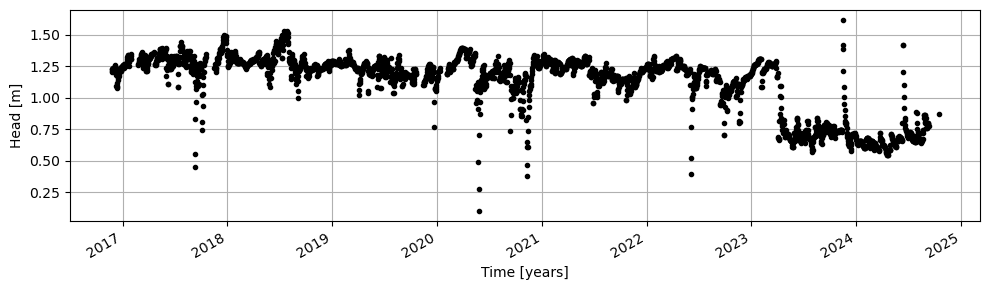

In [7]:
head.plot(linestyle="", marker=".", color="k", figsize=(10, 3))
plt.ylabel('Head [m]')
plt.xlabel('Time [years]')
plt.grid();

#### Precipitation

In [9]:
prec = pd.read_csv('Prec_temp/Miami_4008629.csv', delimiter=',', index_col=0, skiprows=0, usecols=['DATE', 'PRCP'], 
        parse_dates=True
    ).squeeze()
pd.to_datetime(prec.index)
PRCP = prec.sort_index()

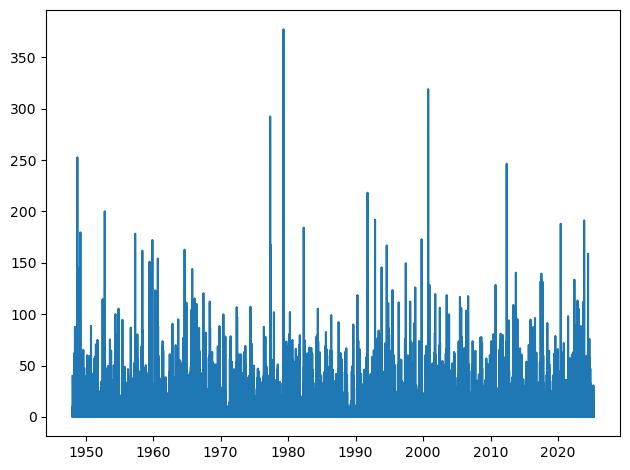

In [10]:
plt.plot(PRCP)

#### Evaporation

In [11]:
evap = pd.read_csv('Evap/Miami.csv', delimiter=',', index_col=0, skiprows=0, usecols=['DATE', 'Hargreaves'], 
        parse_dates=True
    ).squeeze()
pd.to_datetime(evap.index)
EPOT = evap.sort_index()

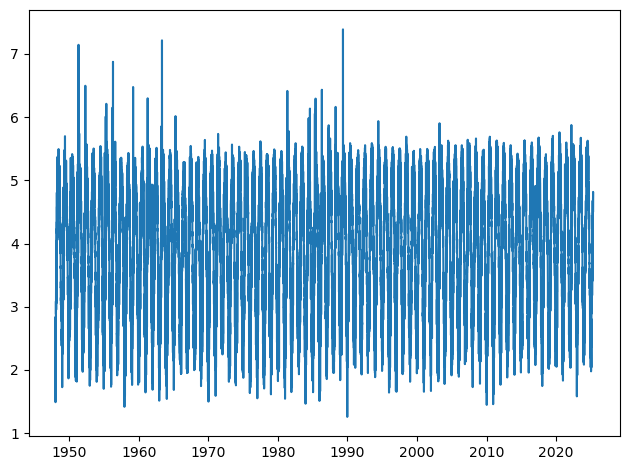

In [12]:
plt.plot(EPOT)

### Pastas Application

#### Resampling data for evenly spaced time steps

In [13]:
PRCP = PRCP.resample("24h", closed="right", label="right").mean()
EPOT = EPOT.resample("24h", closed="right", label="right").mean()

#### Basic Pastas Model

In [14]:
ml = ps.Model(head)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name='rch')
ml.add_stressmodel(sm)
ml.solve()

INFO: Time Series 'PRCP': 1 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 1 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 1 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 1 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 1 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 1 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                   Fit Statistics
nfev    157                    EVP          69.64
nobs    2749                   R2            0.70
noise   False                  RMSE          0.13
tmin    2016-11-24 00:00:00    AICc     -11270.94
tmax    2024-10-15 00:00:00    BIC      -11241.36
freq    D                      Obj          22.70
warmup  3650 days 00:00:00     ___               
solver  LeastSquares           Interp.         No

Parameters (5 optimized)
               optimal    initial  vary
rch_A         7.811033   0.078110  True
rch_n       100.000000   1.000000  True
rch_a        58.885340  10.000000  True
rch_f        -1.068517  -1.000000  True
constant_d    1.280896   1.125433  True

Warnings! (3)
Parameter 'rch_A' on upper bound: 7.81e+00
Parameter 'rch_n' on upper bound: 1.00e+02
Response tmax for 'rch' > than calibration period.


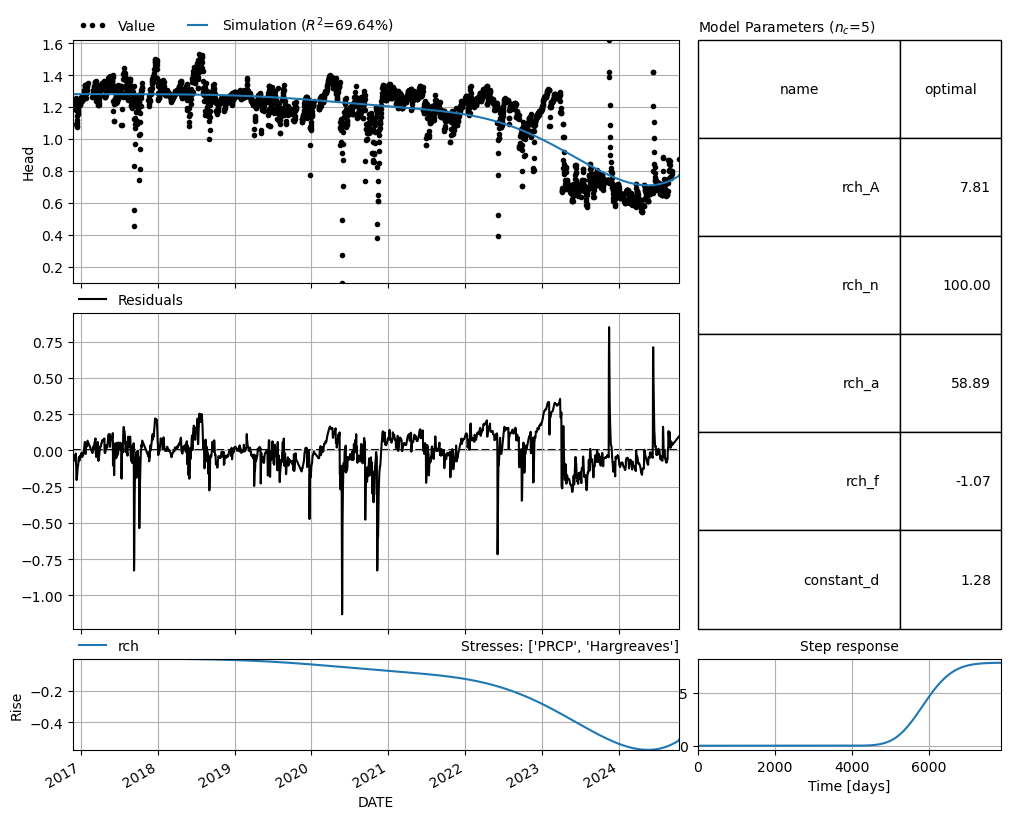

In [15]:
ml.plots.results();

#### Add a Step-Trend

In [29]:
ml = ps.Model(head)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name='rch')
ml.add_stressmodel(sm)

step = ps.StepModel(tstart=pd.Timestamp("2023-04-01"), name="step", up=None)
ml.add_stressmodel(step)

ml.solve();

INFO: Time Series 'PRCP': 1 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 1 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 1 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 1 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 1 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 1 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                   Fit Statistics
nfev    224                    EVP          77.58
nobs    2749                   R2            0.78
noise   False                  RMSE          0.11
tmin    2016-11-24 00:00:00    AICc     -12101.86
tmax    2024-10-15 00:00:00    BIC      -12066.38
freq    D                      Obj          16.76
warmup  3650 days 00:00:00     ___               
solver  LeastSquares           Interp.         No

Parameters (6 optimized)
                   optimal        initial   vary
rch_A             0.031543       0.078110   True
rch_n            99.999999       1.000000   True
rch_a            45.808477      10.000000   True
rch_f            -2.000000      -1.000000   True
step_d           -0.483913       1.000000   True
step_tstart  738611.000000  738611.000000  False
constant_d        1.295225       1.125433   True

Warnings! (3)
Parameter 'rch_n' on upper bound: 1.00e+02
Parameter 'rch_f' on lower bound: -2.00e+00
Response tmax for 'rch' > than

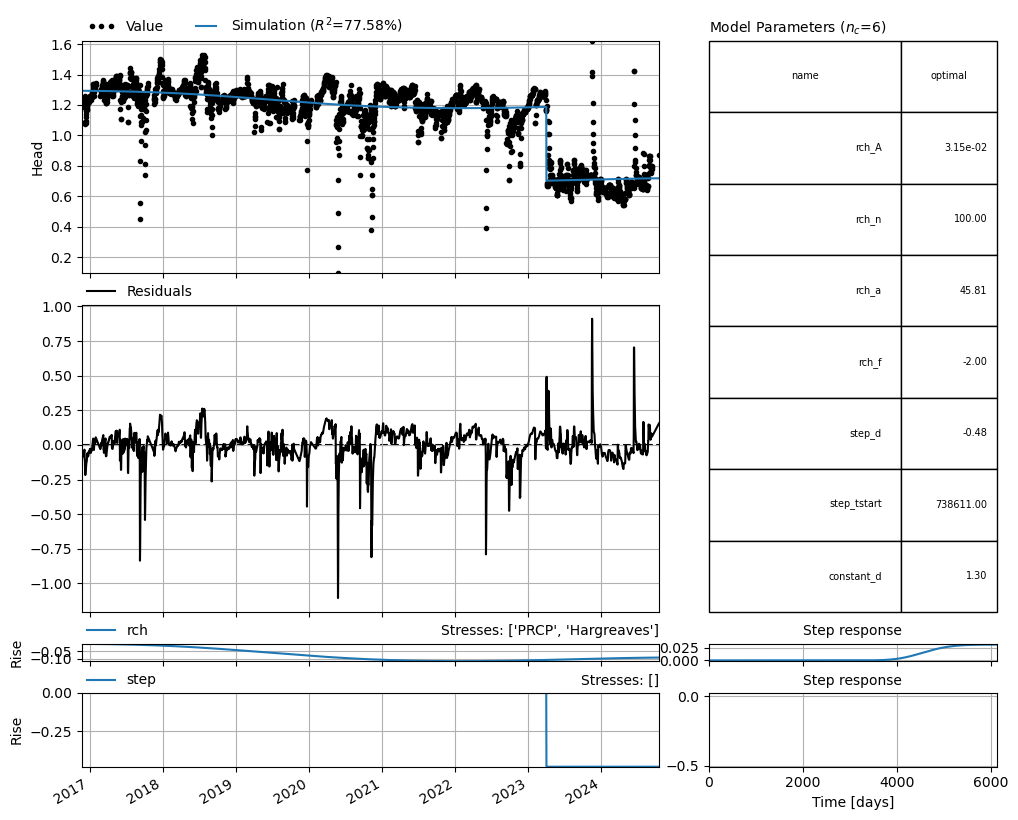

In [30]:
ml.plots.results();

#### Different recharge models and response functions

In [31]:
ml = ps.Model(head)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name="rch", recharge=ps.rch.Peterson())
ml.add_stressmodel(sm)

step = ps.StepModel(tstart=pd.Timestamp("2023-04-01"), name="step", up=None)
ml.add_stressmodel(step)

ml.solve()

INFO: Time Series 'PRCP': 1 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 1 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 1 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 1 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 1 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 1 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                   Fit Statistics
nfev    36                     EVP          76.50
nobs    2749                   R2            0.76
noise   False                  RMSE          0.11
tmin    2016-11-24 00:00:00    AICc     -11964.33
tmax    2024-10-15 00:00:00    BIC      -11905.22
freq    D                      Obj          17.57
warmup  3650 days 00:00:00     ___               
solver  LeastSquares           Interp.         No

Parameters (10 optimized)
                   optimal        initial   vary
rch_A             2.476999       0.538118   True
rch_n             1.588828       1.000000   True
rch_a           475.476818      10.000000   True
rch_scap          1.911073       1.500000   True
rch_alpha         1.298287       1.000000   True
rch_ksat          0.718709       1.000000   True
rch_beta          0.962791       0.500000   True
rch_gamma         0.291184       1.000000   True
step_d           -0.573944       1.000000   True
step_tstart  738611.000000  73861

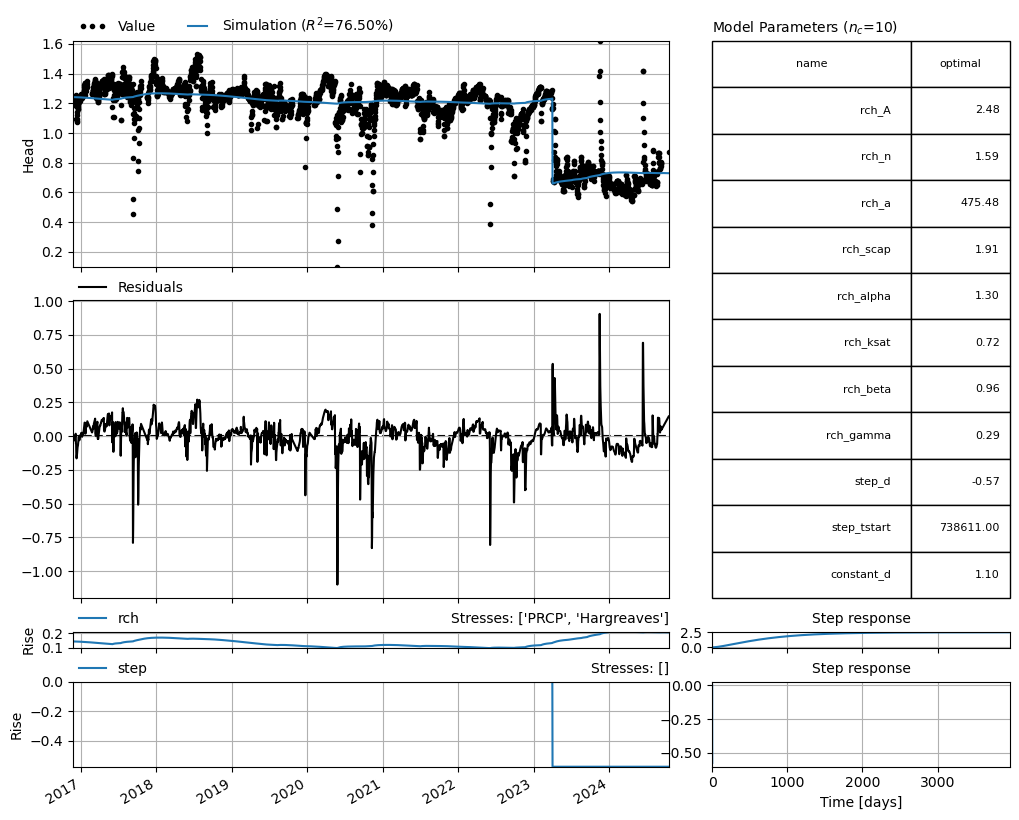

In [32]:
ml.plots.results();

In [43]:
ml = ps.Model(head)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Exponential(), name="rch", recharge=ps.rch.FlexModel())
ml.add_stressmodel(sm)

step = ps.StepModel(tstart=pd.Timestamp("2023-04-01"), name="step", up=None)
ml.add_stressmodel(step)

ml.solve()

INFO: Time Series 'PRCP': 1 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 1 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 1 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 1 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 1 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 1 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                   Fit Statistics
nfev    34                     EVP          74.93
nobs    2749                   R2            0.75
noise   False                  RMSE          0.12
tmin    2016-11-24 00:00:00    AICc     -11792.92
tmax    2024-10-15 00:00:00    BIC      -11751.53
freq    D                      Obj          18.74
warmup  3650 days 00:00:00     ___               
solver  LeastSquares           Interp.         No

Parameters (7 optimized)
                   optimal        initial   vary
rch_A             0.008155       0.201377   True
rch_a           485.418116      10.000000   True
rch_srmax       351.721973     250.000000   True
rch_lp            0.250000       0.250000  False
rch_ks           36.132041     100.000000   True
rch_gamma         6.222956       2.000000   True
rch_kv            1.000000       1.000000  False
rch_simax         2.000000       2.000000  False
step_d           -0.512096       1.000000   True
step_tstart  738611.000000  738611

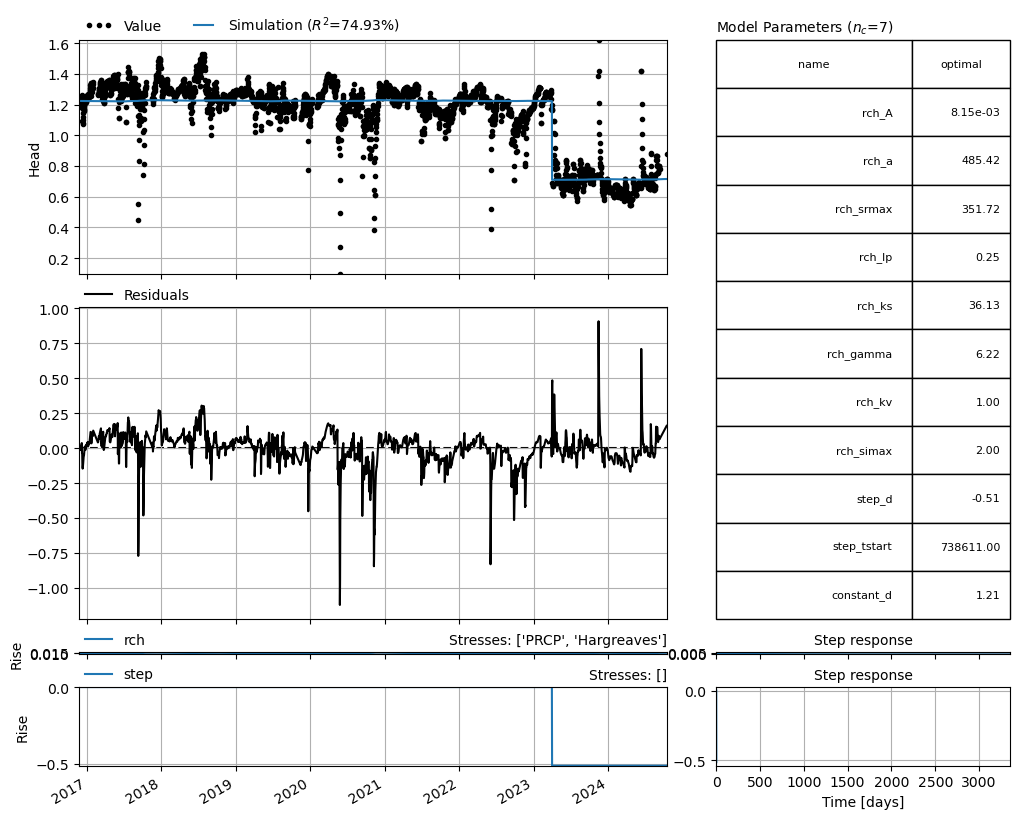

In [44]:
ml.plots.results();

#### Add Groundwater Uptake

As the groundwater is very close to the surface, the gw_uptake feature can be applied

In [46]:
ml1 = ps.Model(head)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Gamma(), name="rch", recharge=ps.rch.FlexModel(gw_uptake=True))
ml1.add_stressmodel(sm)

step = ps.StepModel(tstart=pd.Timestamp("2023-04-01"), name="step", up=None)
ml1.add_stressmodel(step)

ml1.solve()

INFO: Time Series 'PRCP': 1 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 1 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 1 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 1 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 1 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 1 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                   Fit Statistics
nfev    19                     EVP          74.92
nobs    2749                   R2            0.75
noise   False                  RMSE          0.12
tmin    2016-11-24 00:00:00    AICc     -11788.15
tmax    2024-10-15 00:00:00    BIC      -11734.94
freq    D                      Obj          18.75
warmup  3650 days 00:00:00     ___               
solver  LeastSquares           Interp.         No

Parameters (9 optimized)
                   optimal        initial   vary
rch_A             0.000010       0.175423   True
rch_n            16.002456       1.000000   True
rch_a          1730.556218      10.000000   True
rch_srmax       238.581018     250.000000   True
rch_lp            0.250000       0.250000  False
rch_ks           77.990679     100.000000   True
rch_gamma         6.781063       2.000000   True
rch_kv            1.000000       1.000000  False
rch_simax         2.000000       2.000000  False
rch_gf            0.679478       1

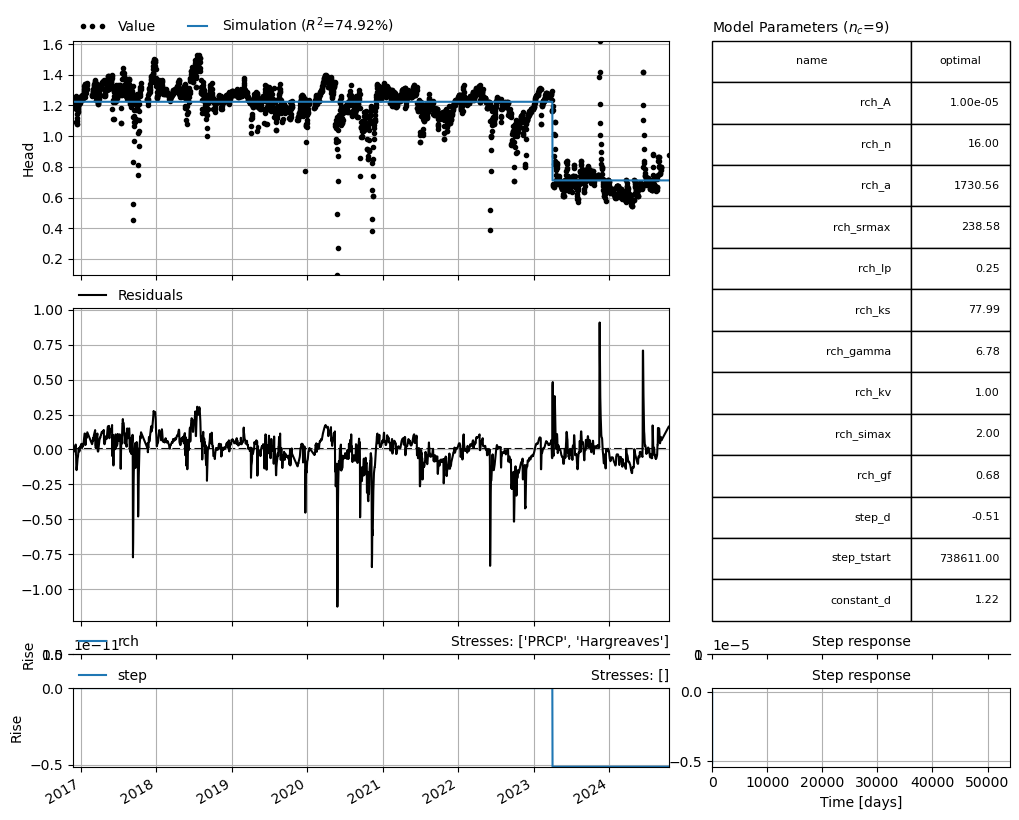

In [47]:
ml1.plots.results();

#### Plot until the Step Trend

In [57]:
ml = ps.Model(head)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Spline(), name="rch", recharge=ps.rch.Peterson())
ml.add_stressmodel(sm)


ml.solve(tmax='2023-04-01')

INFO: Time Series 'PRCP': 1 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 1 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 1 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 1 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 1 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 1 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                   Fit Statistics
nfev    193                    EVP          26.08
nobs    2220                   R2            0.26
noise   False                  RMSE          0.10
tmin    2016-11-24 00:00:00    AICc     -10171.56
tmax    2023-04-01 00:00:00    BIC      -10074.85
freq    D                      Obj          11.19
warmup  3650 days 00:00:00     ___               
solver  LeastSquares           Interp.         No

Parameters (17 optimized)
                 optimal   initial   vary
rch_A       2.276140e+00  0.538118   True
rch_1       6.903259e-14  0.090909   True
rch_2       3.743404e-23  0.181818   True
rch_4       9.325485e-17  0.272727   True
rch_8       9.422370e-23  0.363636   True
rch_16      3.930266e-13  0.454545   True
rch_32      2.610748e-14  0.545455   True
rch_64      8.794283e-02  0.636364   True
rch_128     7.779483e-02  0.727273   True
rch_256     1.565418e-01  0.818182   True
rch_512     1.672174e-01  0.909091   True
rch_1024    1.00000

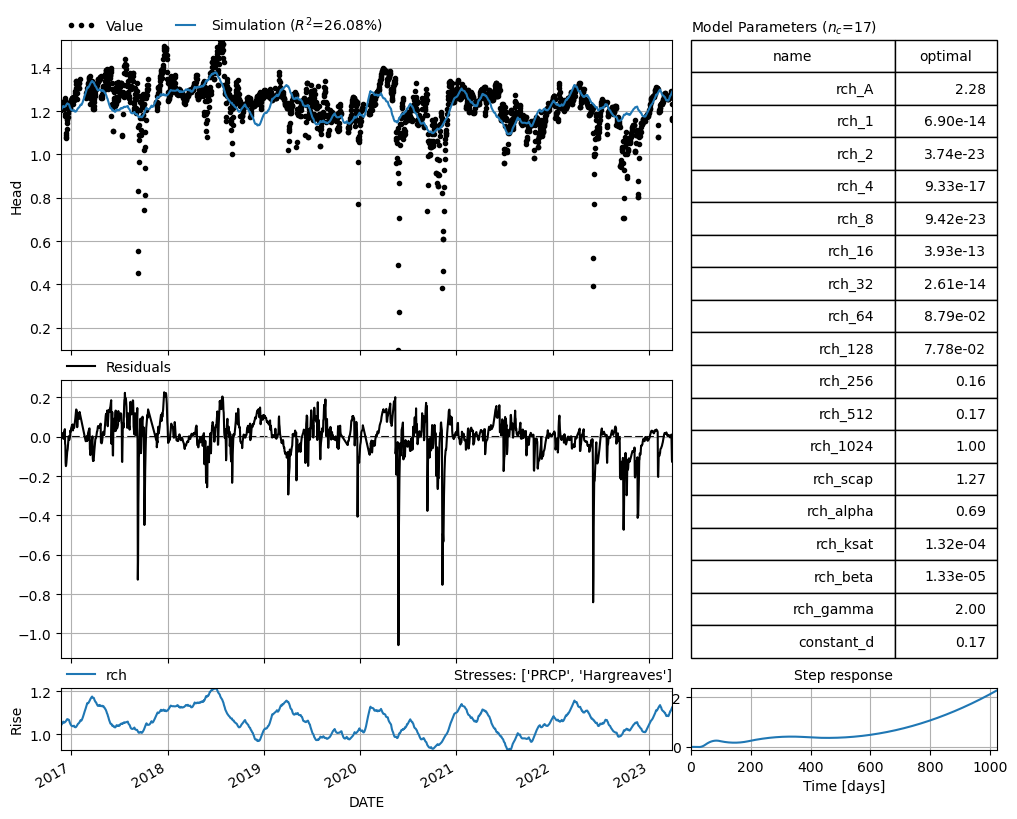

In [59]:
ml.plots.results();

In [60]:
ml = ps.Model(head)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Spline(), name="rch", recharge=ps.rch.FlexModel(gw_uptake=True))
ml.add_stressmodel(sm)


ml.solve(tmax='2023-04-01')

INFO: Time Series 'PRCP': 1 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 1 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 1 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 1 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 1 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 1 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                  Fit Statistics
nfev    29                     EVP         18.82
nobs    2220                   R2           0.19
noise   False                  RMSE         0.11
tmin    2016-11-24 00:00:00    AICc     -9965.51
tmax    2023-04-01 00:00:00    BIC      -9874.48
freq    D                      Obj         12.29
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (16 optimized)
                 optimal     initial   vary
rch_A       1.310109e-01    0.175423   True
rch_1       2.771274e-19    0.090909   True
rch_2       2.476865e-17    0.181818   True
rch_4       3.391751e-22    0.272727   True
rch_8       2.498143e-12    0.363636   True
rch_16      3.407264e-20    0.454545   True
rch_32      6.965777e-15    0.545455   True
rch_64      1.389859e-01    0.636364   True
rch_128     1.392478e-01    0.727273   True
rch_256     4.658223e-01    0.818182   True
rch_512     7.122374e-01    0.909091   True
rch_

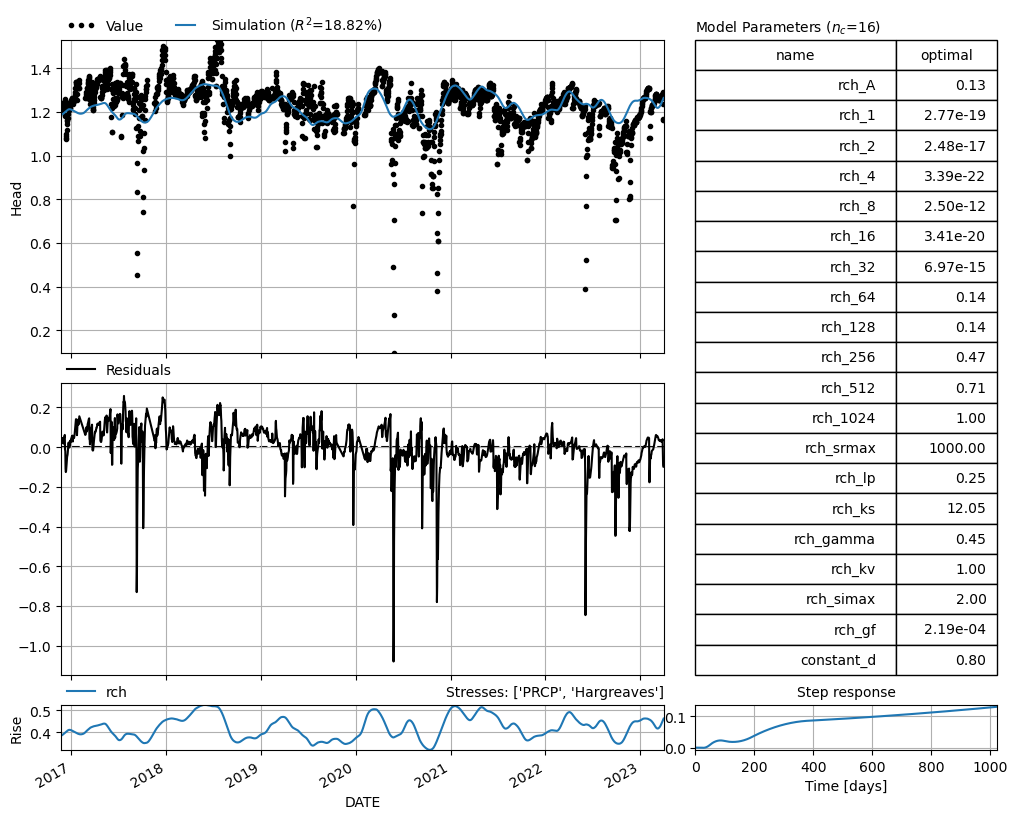

In [61]:
ml.plots.results();

#### Resample Monthly

In [62]:
head_resampled = head.resample('M').last()

In [67]:
ml = ps.Model(head_resampled)
sm = ps.RechargeModel(PRCP, EPOT, rfunc=ps.Spline(), name="rch", recharge=ps.rch.FlexModel(gw_uptake=True))
ml.add_stressmodel(sm)


ml.solve(tmax='2023-04-01')

INFO: Time Series 'PRCP': 1 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 1 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 1 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 1 nan-value(s) was/were found and filled with: interpolate.
INFO: Time Series 'PRCP': 1 nan-value(s) was/were found and filled with: 0.0.
INFO: Time Series 'Hargreaves': 1 nan-value(s) was/were found and filled with: interpolate.


Fit report Value                 Fit Statistics
nfev    38                     EVP        20.17
nobs    77                     R2          0.20
noise   False                  RMSE        0.08
tmin    2016-11-30 00:00:00    AICc     -340.10
tmax    2023-04-01 00:00:00    BIC      -311.67
freq    D                      Obj         0.27
warmup  3650 days 00:00:00     ___             
solver  LeastSquares           Interp.       No

Parameters (16 optimized)
                 optimal     initial   vary
rch_A       3.370427e-02    0.175423   True
rch_1       4.680953e-10    0.090909   True
rch_2       9.275388e-02    0.181818   True
rch_4       3.775625e-08    0.272727   True
rch_8       1.994874e-16    0.363636   True
rch_16      2.206882e-08    0.454545   True
rch_32      2.210072e-11    0.545455   True
rch_64      2.475052e-01    0.636364   True
rch_128     3.306893e-01    0.727273   True
rch_256     8.934777e-01    0.818182   True
rch_512     1.000000e+00    0.909091   True
rch_1024    1

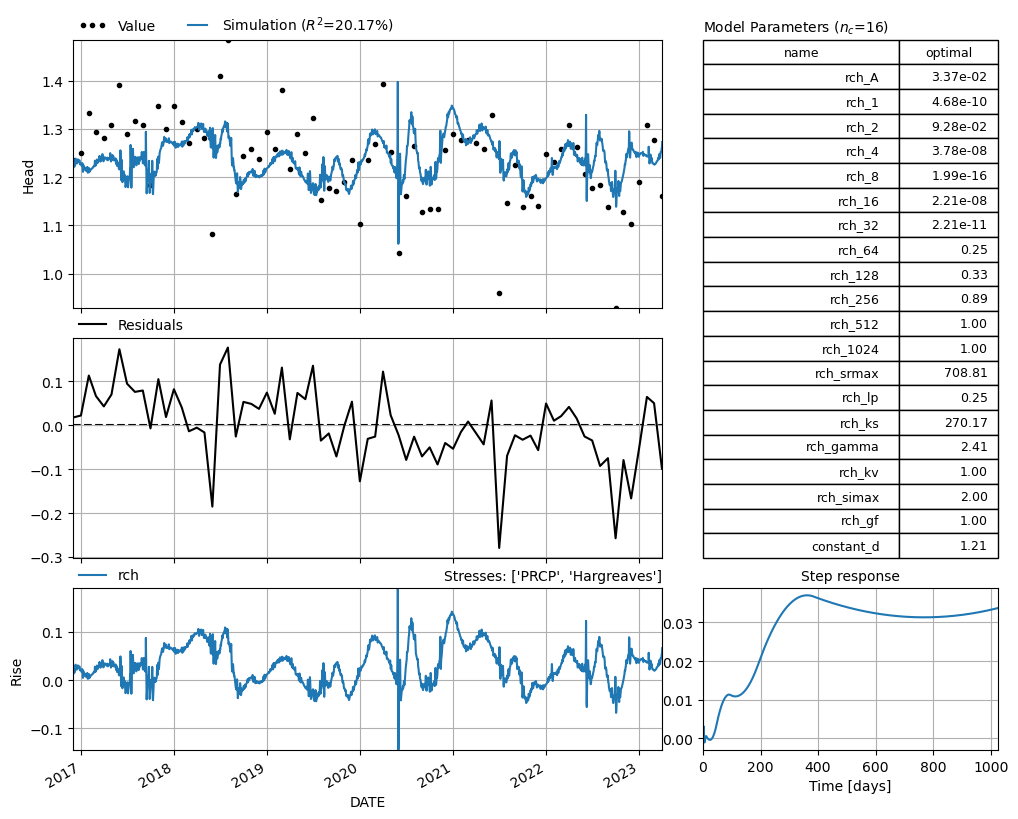

In [68]:
ml.plots.results();